In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.loss import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [4]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [5]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [7]:
volume = Volume(get_layers())

# VolumeWrapper

In [8]:
from functools import partial

In [9]:
volume = Volume(get_layers())

In [10]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e1), eff_opt=partial(torch.optim.SGD, lr=2e-5), loss_func=DetectorLoss(0.025))

In [52]:
%time preds = wrapper.predict(PassiveYielder([arb_rad_length]), n_mu_per_volume=10000, mu_bs=100, use_default_pred=False)

CPU times: user 29.3 s, sys: 4.87 s, total: 34.2 s
Wall time: 29.8 s


In [53]:
%time preds = wrapper.predict(PassiveYielder([arb_rad_length]), n_mu_per_volume=100000, mu_bs=100, use_default_pred=False)

CPU times: user 4min 51s, sys: 48.4 s, total: 5min 40s
Wall time: 4min 57s


In [50]:
def_preds = wrapper.predict(PassiveYielder([arb_rad_length]), n_mu_per_volume=10000, mu_bs=100, use_default_pred=True)

In [48]:
def plot_pred_true_x0(pred:np.ndarray, true:np.ndarray, savename:Optional[str]=None) -> None:
    with sns.axes_style(style="whitegrid", rc={"patch.edgecolor": "none"}):
        fig,axs = plt.subplots(len(pred),2, figsize=(8,8*16/9))
        pred_cbar_ax = fig.add_axes([0.45, 0.25, 0.03, 0.5])
        true_cbar_ax = fig.add_axes([0.90, 0.25, 0.03, 0.5])
        
        for i in range(len(pred)):
            sns.heatmap(pred[i],ax=axs[i][0], cmap='viridis', square=True,
                    cbar=(i == 0),
                    vmin=np.nanmin(pred),
                    vmax=np.nanmax(pred),
                    cbar_ax=pred_cbar_ax if i == 0 else None)
            sns.heatmap(true[i],ax=axs[i][1], cmap='viridis', square=True,
                    cbar=(i == 0),
                    vmin=true.min(),
                    vmax=true.max(),
                    cbar_ax=true_cbar_ax if i == 0 else None)

            axs[i][0].set_ylabel(f"Layer {i}", fontsize=24, color='black')
        axs[-1][0].set_xlabel("Prediction", fontsize=24, color='black')
        axs[-1][1].set_xlabel("True", fontsize=24, color='black')
        if savename is not None: plt.savefig(savename, bbox_inches='tight')
        plt.show()

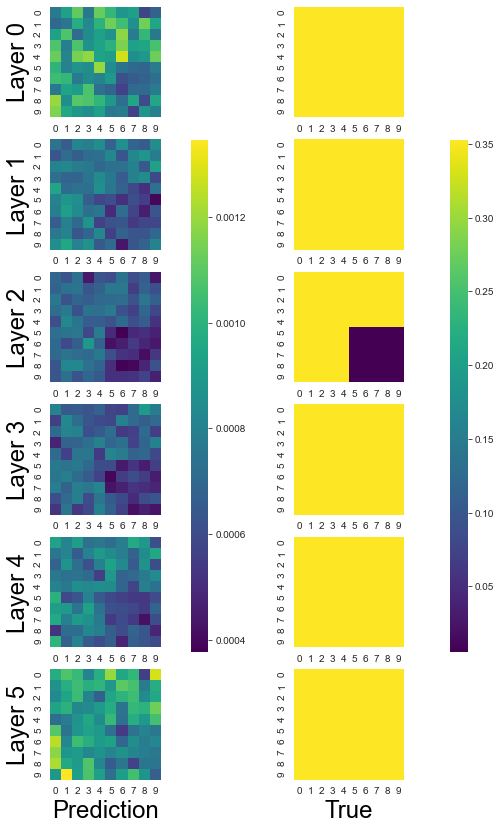

In [54]:
plot_pred_true_x0(*preds[0])

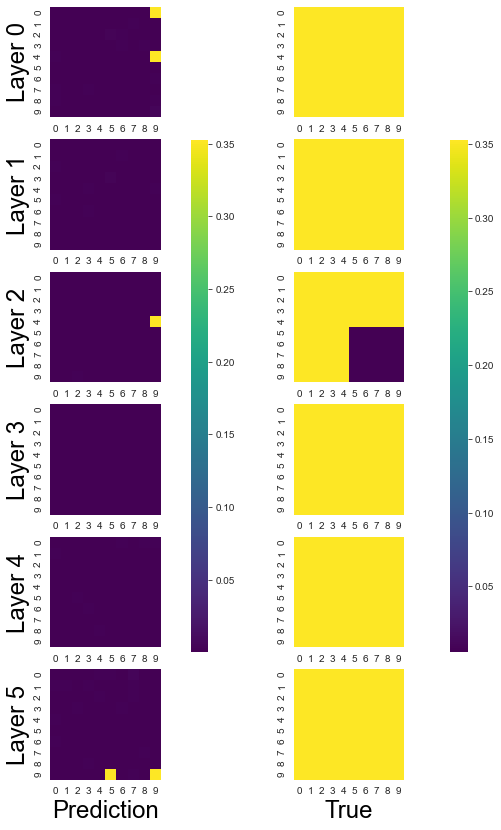

In [51]:
plot_pred_true_x0(*def_preds[0])